# Key performance indicators and evaluations

In [1]:
%load_ext autoreload
%autoreload 2

# 1. Importing Libraries 

In [2]:
import os, sys, pickle
from pathlib import Path

#dir_p = Path().resolve() 
#dir_path = os.path.dirname(os.path.abspath(os.curdir))
#os.chdir(dir_path)

from agrid.grid import Grid


import pandas as pd

import re
import copy

import numpy as np
from numpy import asarray
from numpy import save
from numpy import load

from scipy import stats, interpolate, spatial, io
from scipy.ndimage import gaussian_filter, median_filter
import xarray as xr
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors
import matplotlib as mpl
from matplotlib.patches import Arc 
import cartopy.crs as ccrs

import pyproj as proj
import rasterio


from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error

import seaborn as sns

from joblib import Parallel, delayed
import multiprocessing
import numba as nb
from numba import jit

import warnings
warnings.filterwarnings('ignore')



from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score, max_error, \
median_absolute_error, mean_absolute_percentage_error, mean_poisson_deviance, mean_gamma_deviance


from sklearn.utils import shuffle

from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer , r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error


from sklearn.model_selection import cross_validate
from sklearn.decomposition import PCA


import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(1, figsize=(16, 9))

from sklearn.feature_selection import RFECV,RFE
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import Pipeline

from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso#Loading the dataset



from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

from sklearn.preprocessing import PowerTransformer
from sklearn.compose import TransformedTargetRegressor

from sklearn.compose import ColumnTransformer

from sklearn.compose import make_column_selector as selector


<Figure size 1152x648 with 0 Axes>

define constants and dcitionaries to easy looping

In [3]:
# constanst

#parent directory

dir_p = Path().resolve() 

#constants
km = 1000
milli = 0.001
micro = 0.000001



# We can exclude Arctic ocean and Antarctica, as there are no HF measurements to use
world_lon_min, world_lon_max, world_lat_min, world_lat_max  = -180, 180, -60, 80

# map extents of Africa and Australia
afr_lon_min, afr_lon_max, afr_lat_min, afr_lat_max =  -20, 52, -37 , 38  


# create grid for each region
# crs Coordinate reference system

#EPSG is projection
# 0.2 degrees equal roughly 20 km

World = Grid(res=[0.2, 0.2], up=world_lat_max, down=world_lat_min)


# africa grid low resolution 50 x 50 km

Africa =    Grid(res=[0.5, 0.5],  left = afr_lon_min, right= afr_lon_max, up=afr_lat_max , down=afr_lat_min)


#dictionary of all grids

grids = {}

grids['Afr'] = Africa
grids['World'] = World


In [4]:
# to ease looping with dictionaries

regions_a = [ 'Afr' ]


regions_Total = ['World' ,'Afr']


# raster exenets to adjust map
raster_extent_Afr = [grids['Afr'].extent[0], grids['Afr'].extent[1], grids['Afr'].extent[3], grids['Afr'].extent[2]]
raster_extent_World = [grids['World'].extent[0], grids['World'].extent[1], grids['World'].extent[3], grids['World'].extent[2]]

# to correct plot maps
raster_extents = {}

raster_extents['Afr'] = raster_extent_Afr
raster_extents['World'] = raster_extent_World


# list of latitudes and longitudes
lon_dict = {}
lat_dict = {}

lon_dict['Afr'] = [afr_lon_min, afr_lon_max]
lon_dict['World'] = [world_lon_min, world_lon_max]

lat_dict['Afr'] = [afr_lat_min, afr_lat_max]
lat_dict['World'] = [world_lat_min, world_lat_max]



print('terminated')

terminated


In [5]:

class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

In [6]:
def concordance_correlation_coefficient(y_true, y_pred):
    """Concordance correlation coefficient."""
    # Remove NaNs
    df = pd.DataFrame({
        'y_true': y_true,
        'y_pred': y_pred
    })
    df = df.dropna()
    y_true = df['y_true']
    y_pred = df['y_pred']
    # Pearson product-moment correlation coefficients
    cor = np.corrcoef(y_true, y_pred)[0][1]
    # Mean
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    # Variance
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    # Standard deviation
    sd_true = np.std(y_true)
    sd_pred = np.std(y_pred)
    # Calculate CCC
    numerator = 2 * cor * sd_true * sd_pred
    denominator = var_true + var_pred + (mean_true - mean_pred)**2
    return numerator / denominator

In [7]:
obs = pd.DataFrame()


''' 
obs['REF_n'] = [ 'MOHO','LAB', 'RHO_C', 'SV', 'PV', 'CTD',
             'RHO_L', 'DEM', 
                'VOLC_DIST_W', 'A_MEDIAN_W', 'FA', 'SI','LITH_MANTLE', 
                'EMAG2_CLASS', 'GEOID', 'BG',
              'GLIM']'''



obs['OBS_REF'] = ['CTD' ,  'SI',"LAB", "MOHO",
            "SV","PV", 
            'GEOID','FA','DEM','BG', 'EMAG2_CLASS',
                   'RHO_L', 'RHO_C', 
                  'VOLC_DIST_W', 'REG', 'GLIM']




  
     
# Labels for plots etc
obs['LABELS'] = ['CTD',  'Shape index', 'LAB depth', 'Moho depth', 
                'S$_V$ 150km', 'P$_V$ 150km', 
                'Geoid', 'Free air', 'DEM', 'Bouguer', 'Mag.', 
                'Lith. ρ', 'Crust ρ',  
                 'Volcano d.', 'GliM', 'REG', ]  
    
    
# 'vp/vs'
# Units to display in plots etc
obs['UNITS'] = ['km',  'si', 'km', 'km',
             '$\delta$ v_s %','$\delta$ v_p %', 
             'm', 'mGal', 'm', 'mGal',  'f(nT)', 
                 'kg/m$^3$', 'kg/m$^3$',
                'km',  'class', 'class']
        
# Range of colormap for plots. Similar data are placed in same ranges for consistancy
obs['V_RANGE'] = [(0,50), (-1,1),(0,300),(15,60),
              (-0.075,0.075), (-0.02,0.02), 
              (-45,45), (-100,100) , (-2200, 2200),(-250,100),  (-0.4, 0.4), 
                   (3260, 3360), (2650, 2950),
                  (0,1), (1,6),(1,15),]
    
obs["CMAPS"] = ["batlow",  "broc", "bamako", "batlow", 
             "roma","roma", 
             "bamako", "broc", "bukavu", "broc", "batlow",            
                "batlow", "batlow",
               "bamako",  "batlowS","topo", ]

#new_index = [4,3,15,6,7,0,14,10,16,17,9, 2,1,5,13,12, 8,11,]

#new_index = [4,3,15,6,7,0, 14, 10,16, 8, 9,2, 13, 12, 8, 11, ]

#obs = obs.reindex(new_index)

obs.index = np.arange(0,len(obs))

pd.options.display.width = 370
pd.options.display.max_colwidth = 12
print(obs)

n_obs = len(obs)

obs_dict = obs.to_dict(orient='records')



        OBS_REF       LABELS        UNITS      V_RANGE    CMAPS
0           CTD          CTD           km      (0, 50)   batlow
1            SI  Shape index           si      (-1, 1)     broc
2           LAB    LAB depth           km     (0, 300)   bamako
3          MOHO   Moho depth           km     (15, 60)   batlow
4            SV  S$_V$ 150km  $\delta$...  (-0.075,...     roma
5            PV  P$_V$ 150km  $\delta$...  (-0.02, ...     roma
6         GEOID        Geoid            m    (-45, 45)   bamako
7            FA     Free air         mGal  (-100, 100)     broc
8           DEM          DEM            m  (-2200, ...   bukavu
9            BG      Bouguer         mGal  (-250, 100)     broc
10  EMAG2_CLASS         Mag.        f(nT)  (-0.4, 0.4)   batlow
11        RHO_L      Lith. ρ     kg/m$^3$  (3260, 3...   batlow
12        RHO_C      Crust ρ     kg/m$^3$  (2650, 2...   batlow
13  VOLC_DIST_W   Volcano d.           km       (0, 1)   bamako
14          REG         GliM        clas

In [8]:

target = 'heat-flow (mW/m2)'
coord = ['lon', 'lat']
grid_index = ['grid_index']


#######

features_ex = []
features_ghf = []



features = obs['OBS_REF'].tolist()



in_features = set(features)

features_ex = copy.deepcopy(features)
features_ex.extend(coord)
features_ex.extend(grid_index)

features_ex.append(target)

features_ghf = copy.deepcopy(features)
features_ghf.append(target)




# comaprison

In [14]:


files = [
         'OD_rab',
         'NOD_rab',
        ]

observables = [ 
            features, 
            features, 
]



for file_label, observable in zip(files, observables):
    
     
    KPI_df = pd.DataFrame()

    #### training
    tarin_w_f =  dir_p/ 'data'/'dataset'/'Preprocessed'/f'Training_W_{file_label}.csv'

    train_W = pd.read_csv(tarin_w_f, sep='\t')

    
    X = train_W[observable] 
    y = train_W[target]
    X['GLIM']  = X['GLIM'].astype('int').astype('category')
    X['REG']  = X['REG'].astype('int').astype('category')
    
    X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)

    # hyperparameter
    bs_rfr_hyp =  dir_p/'Hyperparameters'/f'RFR_{file_label}.csv'


    bs_rfr_hyp_df = pd.read_csv(bs_rfr_hyp, sep='\t')


    best_params = bs_rfr_hyp_df.to_dict('list')


    # Load hyper parameter 

    regressor = RandomForestRegressor()

    tuned_params = {item[11:]: best_params[item][0] for item in best_params}
    regressor.set_params(**tuned_params)

    scaler = PowerTransformer(method='yeo-johnson',standardize=True)


    numeric_transformer = scaler

    categorical_transformer = OrdinalEncoder(handle_unknown='use_encoded_value' , unknown_value =-1)


    preprocessor = ColumnTransformer(
        transformers=[
       ("num", numeric_transformer, selector(dtype_exclude="category")),
            ("cat", categorical_transformer, selector(dtype_include="category")),
        ]
    )


    # Append classifier to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    steps=[("preprocessor", preprocessor), ("regressor", regressor)]

    
    # Initialize Pipeline object
    pipeline= Pipeline(steps = steps)

    model_pipeline = TransformedTargetRegressor(regressor=pipeline, transformer=scaler)



    model_pipeline.fit(X_train, y_train)

    y_predict = model_pipeline.predict(X_test)

    print('optimized')

    errors      = abs(y_test - y_predict)
    mape        = round( mean_absolute_percentage_error(y_test, y_predict), 2)  
    accuracy    = round(100 - mape*100, 2)
    mae         = round(mean_absolute_error(y_test, y_predict ), 2)
    rmse        = round(mean_squared_error(y_test, y_predict , squared=False), 2)
    nrmse       = round( rmse/(y_test.mean()) , 2)
    r2          = round(r2_score(y_test, y_predict ), 2)
    ev          = round( explained_variance_score(y_test, y_predict), 2)
    max_e       = round( max_error(y_test, y_predict), 2)
    min_e       = round( errors.min(), 2)
    mnae        = round( median_absolute_error(y_test, y_predict), 2) 
    #mpd         = round( mean_poisson_deviance(y_test, y_predict), 2) 
    #mgd         = round( mean_gamma_deviance(y_test, y_predict), 2) 
    # # Mean Absolute Error (MAE)
    mpe         =  round(np.mean((y_test -y_predict)/y_test) , 2)
    ccc         =   round( concordance_correlation_coefficient(y_test, y_predict), 2) 



    KPI_df.loc['NRMSE', f'{file_label}'] = nrmse
    KPI_df.loc['RMSE', f'{file_label}'] = rmse
    KPI_df.loc['MAE', f'{file_label}'] = mae
    KPI_df.loc['MAPE', f'{file_label}'] = mape
    KPI_df.loc['$R^2$', f'{file_label}'] = r2
    KPI_df.loc['EV', f'{file_label}'] = ev
    KPI_df.loc['MAX_E', f'{file_label}'] = max_e
    KPI_df.loc['MIN_E', f'{file_label}'] = min_e
    KPI_df.loc['MedAE', f'{file_label}'] = mnae
    KPI_df.loc['MPE', f'{file_label}'] = mpe
    KPI_df.loc['MAX', f'{file_label}'] = round(y_predict.max(),1)
    KPI_df.loc['MIN', f'{file_label}'] = y_predict.min()
    KPI_df.loc['ACC', f'{file_label}'] = accuracy
    KPI_df.loc['Mean', f'{file_label}'] = round(np.mean(y_predict),2)
    KPI_df.loc['Median', f'{file_label}'] = round(np.median(y_predict),2)
    KPI_df.loc['Stdev', f'{file_label}'] = round(np.std(y_predict),2)
    KPI_df.loc['RSD', f'{file_label}'] = round(np.std(y_predict) / np.mean(y_predict) ,2)
    KPI_df.loc['CCC', f'{file_label}'] = ccc
    #save results
    kpi_f =  dir_p/'KPI'/f'KPI_{file_label}.csv'

    KPI_df.to_csv(kpi_f , sep='\t')
    
    
    print(f'terminated {file_label}')

print('terminated')


optimized
terminated OD_rab
optimized
terminated NOD_rab
terminated


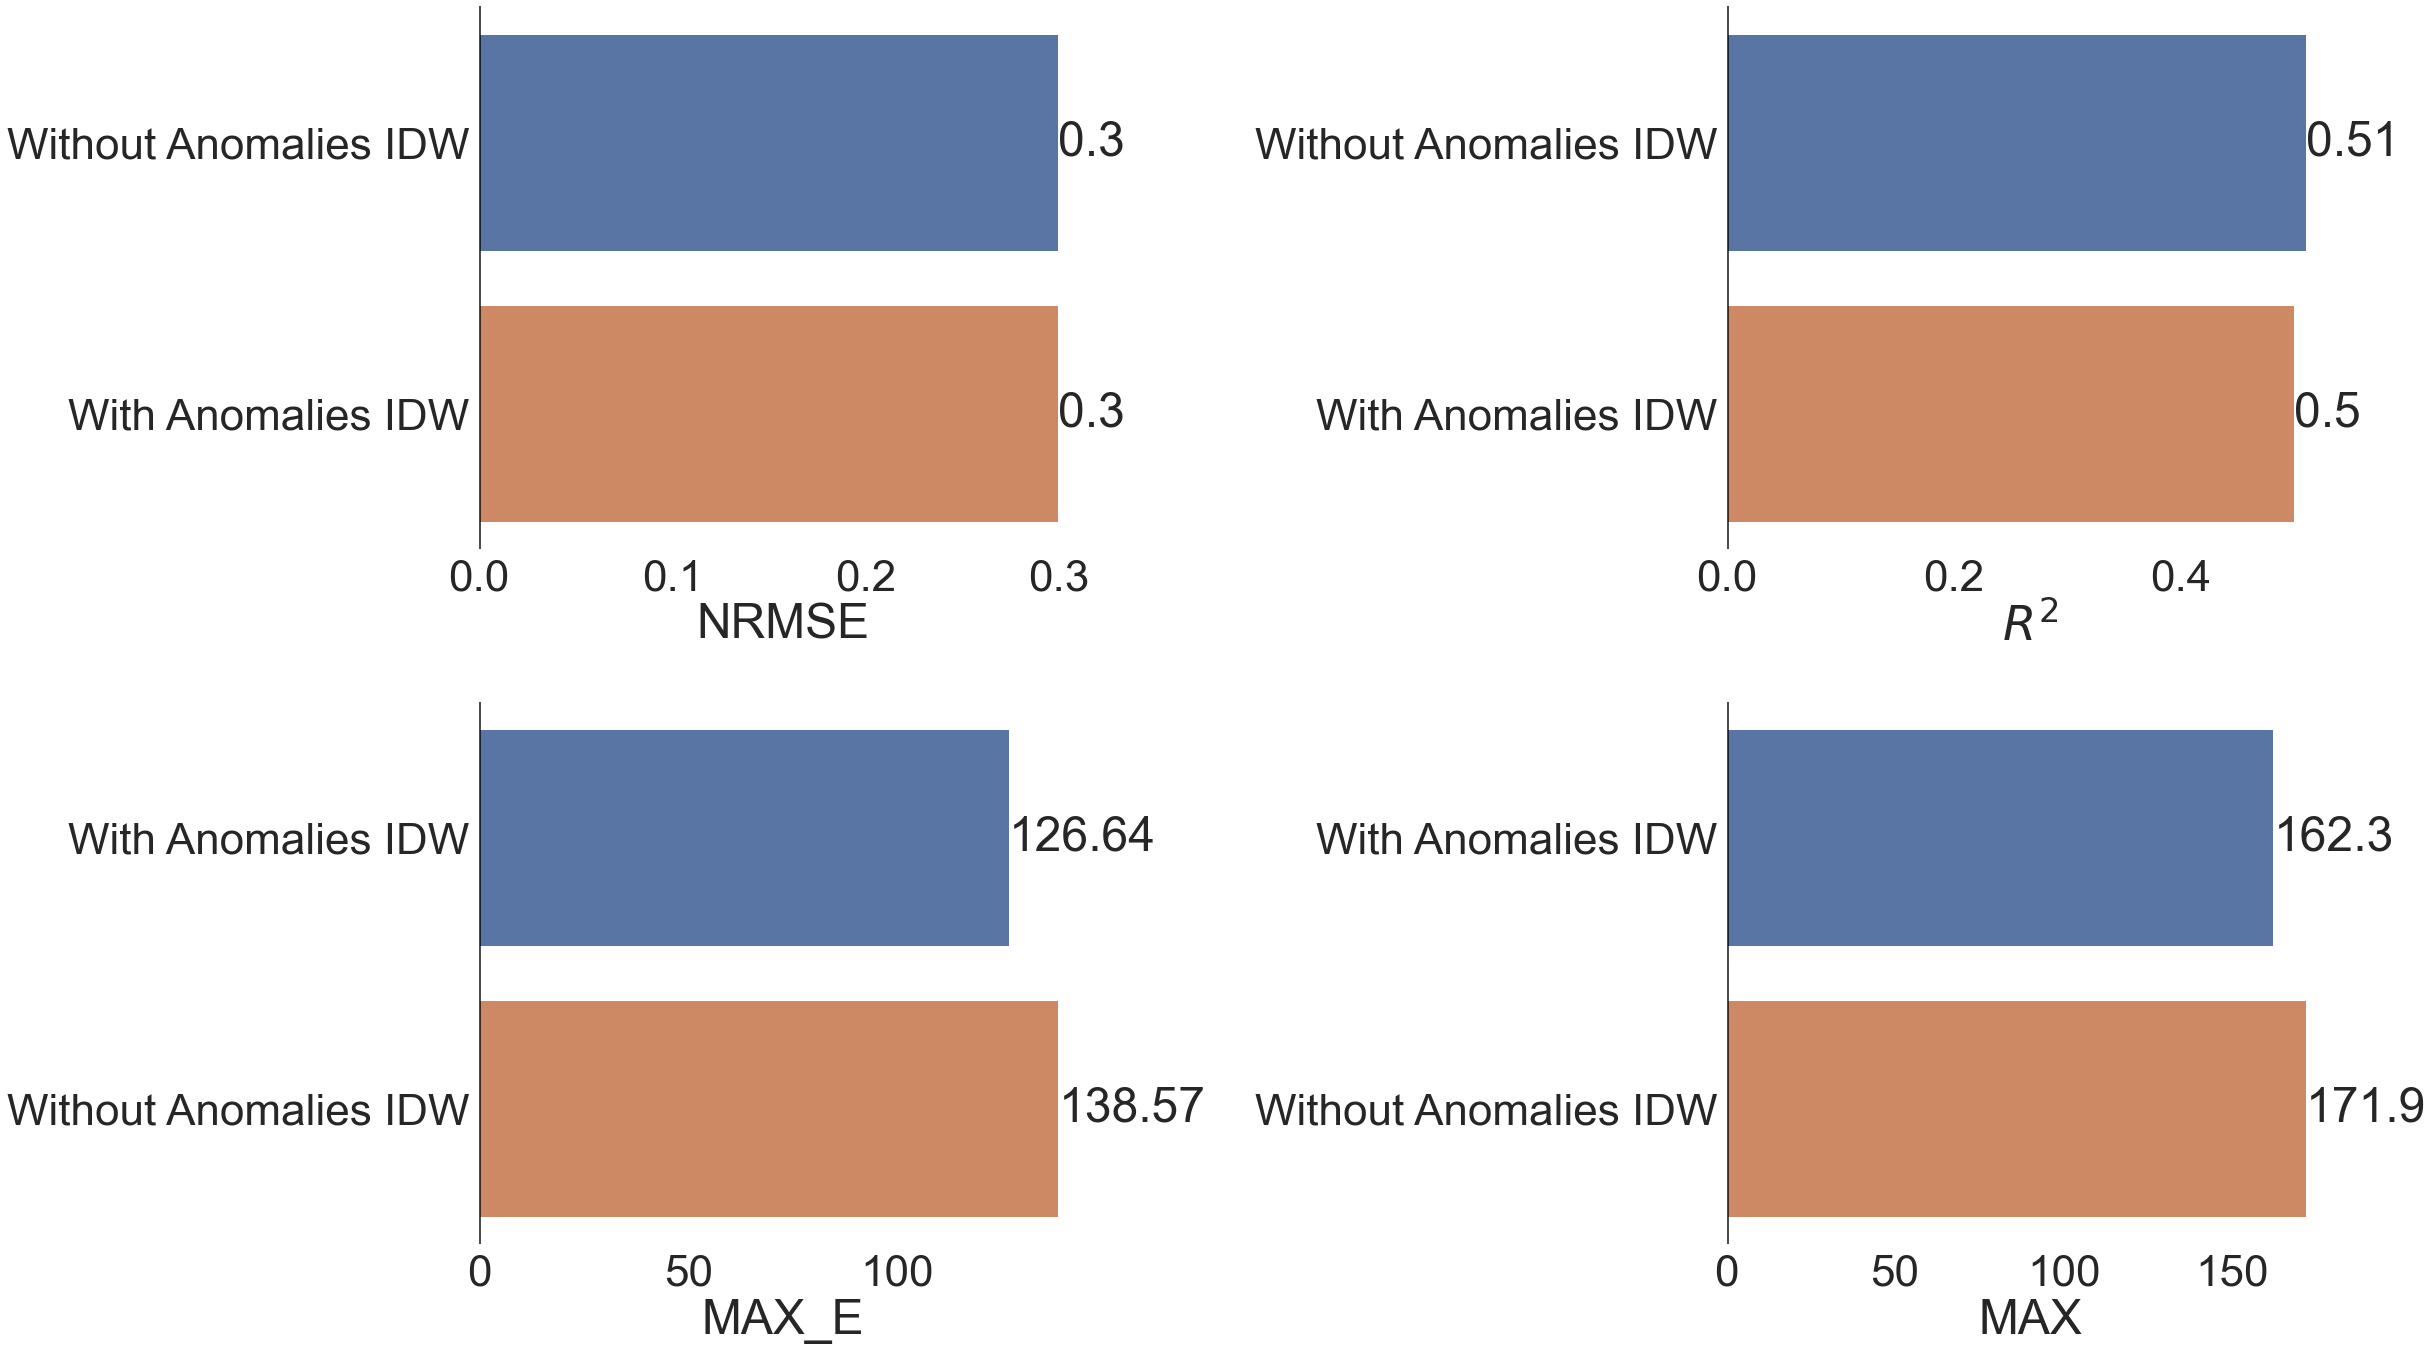

In [23]:
KPI_df = pd.DataFrame()
files = [filename for filename in os.listdir(dir_p/'KPI')  if 'rab' in filename]
for file in zip(files):
    path = dir_p/'KPI'/f'{file[0]}'
    tmp_df = pd.read_csv(path, index_col=0, sep='\t')
    KPI_df = pd.concat([tmp_df, KPI_df], axis=1)
    
KPI_df.columns = ['Without Anomalies IDW', 'With Anomalies IDW']

# Initialize auc_score dictionary

# Set figure size and create barplot

fig, axs = plt.subplots(2,2,figsize=(35, 20))

sns.set(font_scale = 4)

#fig.set_size_inches(30,30)

#scores = ['RMSE', 'NRMSE','MAE', 'MAPE', 'CD','EV', 'MAX_E','MIN_E' ,'MedAE', 'MPE']
scores = ['RMSE', 'MAE', 'NRMSE','MAPE', 'CD','EV', 'MAX_E', 'MAX', 'Stdev', 
          'RSD', 'Mean','Median','MedAE', 'MPE', 'ACC', 'CCC']

scores = ['NRMSE','$R^2$','MAX_E', 'MAX']
#subfile = 'HOD'
#files_rg = [ x for x in files_rg if subfile in x ]
for score, ax in zip(scores, axs.flatten()):



    if score in ['$R^2$','EV' ,'Max', 'MPE', 'ACC','CCC']:
        x_data = KPI_df.loc[score, :].sort_values(ascending=False).index
        y_data = KPI_df.loc[score,:].sort_values(ascending=False)
        bar = sns.barplot(y_data[:], x_data[:] ,     ax=ax)
        bar.bar_label(ax.containers[0])

        # Generate a bolded horizontal line at y = 0
        ax.axvline(x = 0, color = 'black', linewidth = 4, alpha = .7)

        # Turn frame off
        ax.set_frame_on(False)

        #ax.legend(loc='upper left')

        # Tight layout
        plt.tight_layout()
    else:
        x_data = KPI_df.loc[score,:].sort_values().index
        y_data = KPI_df.loc[score,:].sort_values()
        bar = sns.barplot(y_data[:], x_data[:] ,     ax=ax)
        bar.bar_label(ax.containers[0], )

        # Generate a bolded horizontal line at y = 0
        ax.axvline(x = 0, color = 'black', linewidth = 4, alpha = .7)

        # Turn frame off
        ax.set_frame_on(False)

        #ax.legend(loc='upper left')

        # Tight layout
        plt.tight_layout()




# Save Figure
#  fig.savefig(dir_p/'fig'/"fig_s4.jpeg", bbox_inches='tight', dpi=300 )


In [24]:

# Save Figure
#plt.savefig(f"{score.__name__} Scores.png", dpi = 1080)

# get data

rating = 'rab'
outlier = 'OD'
file_label = f'{outlier}_{rating}'

tarin_w_f =  dir_p/ 'data'/'dataset'/'Preprocessed'/f'Training_W_{file_label}.csv'
train_W = pd.read_csv(tarin_w_f, sep='\t')



train_W_data = train_W[features_ex]

print(train_W_data.shape)



train_W_data = train_W[features_ex]

print(train_W_data.shape)



X = train_W_data[features]
y = train_W_data[target].values.reshape(-1,1) 
X['GLIM']  = X['GLIM'].astype('int').astype('category')
X['REG']  = X['REG'].astype('int').astype('category')
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)




print(X_train.shape)
print(X_test.shape)

X_train.describe(include='all')



(12463, 20)
(12463, 20)
(9970, 16)
(2493, 16)


,CTD,SI,LAB,MOHO,SV,PV,GEOID,FA,DEM,BG,EMAG2_CLASS,RHO_L,RHO_C,VOLC_DIST_W,REG,GLIM
count,9970.000000,9970.000000,9970.000000,9970.000000,9970.000000,9970.000000,9970.000000,9970.000000,9970.000000,9970.000000,9970.000000,9970.000000,9970.000000,9970.000000,9970.0,9970.0
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,15.0
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3614.0,2418.0
mean,30.808569,-0.008610,126.410839,36.105824,0.016351,-0.002625,-3.401388,-0.541113,532.368806,-63.678184,-0.112741,3309.863578,2801.365932,0.110886,NaN,NaN
std,7.154251,0.482916,55.238910,6.174242,0.034815,0.007178,29.061811,28.168133,754.283726,83.286851,0.329696,28.189406,52.137540,0.239867,NaN,NaN
min,10.234941,-0.978544,63.484222,13.023623,-0.075006,-0.023490,-96.078190,-141.928486,-4345.000000,-525.791010,-1.000000,3256.907565,2690.000229,0.000000,NaN,NaN
25%,25.688190,-0.420755,78.055581,31.424877,-0.013927,-0.006413,-23.881491,-14.618195,52.000000,-118.405474,-0.109952,3283.605915,2760.021157,0.000000,NaN,NaN
50%,29.806866,0.014852,113.379382,35.899753,0.018328,-0.000928,-12.824431,-0.003923,312.000000,-45.252042,-0.018899,3304.801116,2794.950713,0.000000,NaN,NaN
75%,34.970290,0.368315,158.046286,40.540044,0.043999,0.002047,20.027381,15.341074,913.500000,-9.688559,0.047776,3339.366042,2836.230335,0.000000,NaN,NaN
